In [ ]:
import torch
import numpy as np
import skimage
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import glob

# Data process

In [ ]:
arr_data = np.load("/content/drive/MyDrive/U_net_train/latest_dataset.npy") #path of the dataset

In [ ]:
print(f"Number of arrays: {len(arr_data)}")
print(arr_data .shape)


Number of arrays: 10009
(10009, 256, 256, 4)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
categories = [
    [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
 ]
encoder = OneHotEncoder(categories=categories, sparse_output=False)
def onehot(data, n):
    data_flat = data.ravel()
    onehot_encoded = encoder.fit_transform(data_flat.reshape(-1, 1))
    onehot_encoded = onehot_encoded.reshape(256, 256, -1)
    return onehot_encoded


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        image = sample[:,:,:3]  #rgd image
        label = sample[:,:,3]  #label image

        # change date type form numpy to tensor
        if transform is not None:
            image = transform(image)

        label = onehot(label, 10) # (n,256,256,10)
        label = label.transpose(2,0,1)#(n,10, 256,256)
        label = torch.FloatTensor(label)

        return image, label

In [ ]:
carpart = MyDataset(arr_data, transform)
train_size = int(0.95 * len(carpart))   #95% for train
test_size = len(carpart) - train_size #5% for test(Validation)
train_dataset, test_dataset = random_split(carpart, [train_size, test_size])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=True, num_workers=2)

# Achitecture of U2net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate,bias = False)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.interpolate(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

Test

In [ ]:
# def test():
#     x = torch.randn((3, 3, 256, 256))# n = 3, in_channel = 3, h = w =256
#     model = U2NET(in_ch=3,out_ch=10)
#     preds = model(x)
#     print(type(preds))
#     print(len(preds))
#     print(preds[0].shape)
#     print(x.shape)
#     #shape of input and output is same

# test()

<class 'tuple'>
7
torch.Size([3, 10, 256, 256])
torch.Size([3, 3, 256, 256])


# Train

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

In [ ]:
#loss function
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, msk):

	loss0 = bce_loss(d0,msk)
	loss1 = bce_loss(d1,msk)
	loss2 = bce_loss(d2,msk)
	loss3 = bce_loss(d3,msk)
	loss4 = bce_loss(d4,msk)
	loss5 = bce_loss(d5,msk)
	loss6 = bce_loss(d6,msk)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	#print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss


In [ ]:
def train(epo_num=10):


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model = U2NET(in_ch=3,out_ch=10)#input is rgb output is 10 classes
    model = model.to(device)

    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)


    # start timing
    prev_time = datetime.now()
    for epo in trange(epo_num):

        train_loss = 0
        train_tar_loss = 0
        model.train()
        for index, (car, car_msk) in enumerate(train_dataloader):
            # car.shape is torch.Size([12, 3, 256, 256])
            # car_msk.shape is torch.Size([12, 10, 256, 256])

            car = car.to(device)
            car_msk = car_msk.to(device)

            optimizer.zero_grad()

            d0, d1, d2, d3, d4, d5, d6 = model(car)

            loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, car_msk)

            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_tar_loss += loss2.data.item()



        # we don't need to evaluate each epoch, which can help us save training time. only evaluate when we save the model.
        # evaluate each 5 epo
        if np.mod(epo, 5) == 0:
            test_loss = 0
            test_tar_loss =0
            model.eval()

            with torch.no_grad():
                for index, (car, car_msk) in enumerate(test_dataloader):

                    car = car.to(device)
                    car_msk = car_msk.to(device)

                    optimizer.zero_grad()

                    d0, d1, d2, d3, d4, d5, d6 = model(car)

                    loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, car_msk)

                    test_loss += loss.data.item()
                    test_tar_loss += loss2.data.item()

                    del d0, d1, d2, d3, d4, d5, d6, loss2, loss


        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time

        print('epoch:', epo, '/', epo_num)
        print('epoch train loss = %f, train tar loss = %f, %s'
                %(train_loss/len(train_dataloader), train_tar_loss/len(train_dataloader), time_str))

        #save model each 5 epoch
        if np.mod(epo, 5) == 0:

            torch.save(model, '/content/unet_model_{}_loss_trian_{lt:.5f}_val_{lv:.5f}.pt'.format(epo, lt=train_loss/len(train_dataloader), lv=test_loss/len(test_dataloader)))
            print('saving /content/unet_model_{}_loss_trian_{lt:.5f}_val_{lv:.5f}.pt'.format(epo,lt=train_loss/len(train_dataloader), lv = test_loss/len(test_dataloader)))
    return model


if __name__ == "__main__":
    model = train(epo_num=5) #maybe larger

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0 / 5
epoch train loss = 0.358538, train tar loss = 0.049089, epoch test loss = 0.204101, test tar loss = 0.024980,Time 00:11:48


 20%|██        | 1/5 [11:48<47:15, 708.94s/it]

saving /content/unet_model_0_loss_trian_0.35854_val_0.20410.pt


 40%|████      | 2/5 [23:40<35:30, 710.32s/it]

epoch: 1 / 5
epoch train loss = 0.206846, train tar loss = 0.025205, epoch test loss = 0.208081, test tar loss = 0.023584,Time 00:11:51


 60%|██████    | 3/5 [35:27<23:37, 708.82s/it]

epoch: 2 / 5
epoch train loss = 0.161677, train tar loss = 0.018570, epoch test loss = 0.123552, test tar loss = 0.013069,Time 00:11:47


 80%|████████  | 4/5 [47:18<11:49, 709.90s/it]

epoch: 3 / 5
epoch train loss = 0.133217, train tar loss = 0.014289, epoch test loss = 0.107012, test tar loss = 0.010821,Time 00:11:51


100%|██████████| 5/5 [59:04<00:00, 708.85s/it]

epoch: 4 / 5
epoch train loss = 0.127217, train tar loss = 0.013266, epoch test loss = 0.104648, test tar loss = 0.010153,Time 00:11:45


# Test

In [ ]:
import numpy as np
#Use skimage package to deal image
from skimage import io
from skimage.io import imread
import matplotlib.pyplot as plt

from data_process import label2colar,result2image,resize_image_to_256,resize_result_to_original

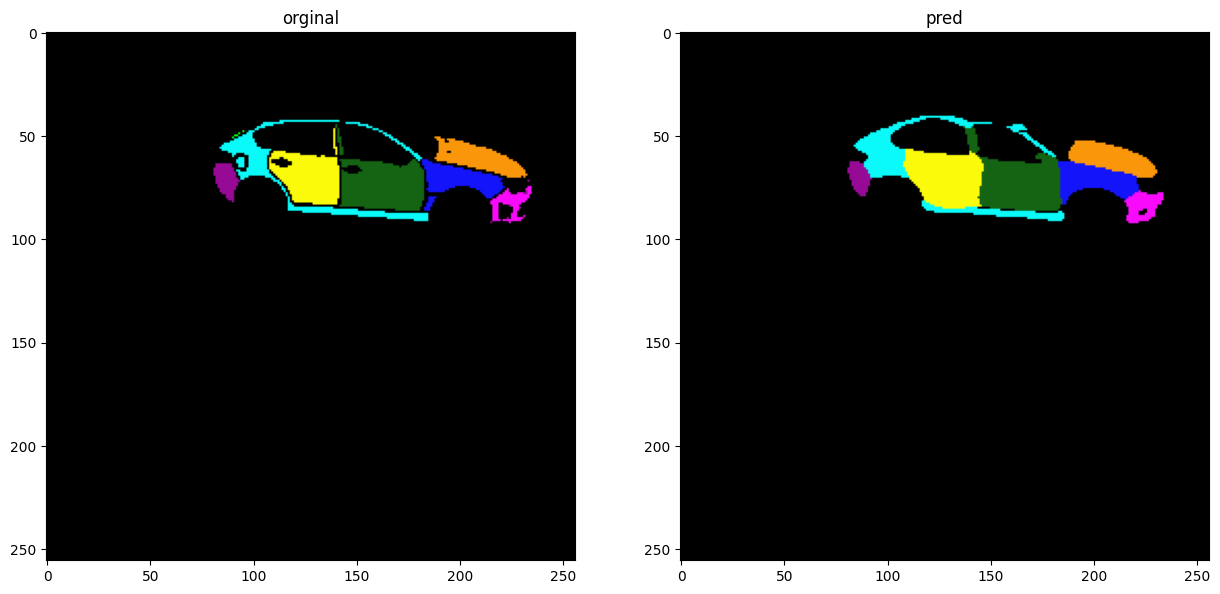

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
black_array = np.load('/content/drive/MyDrive/carseg_data/arrays/black_5_doors_0001.npy')
if __name__ =='__main__':
    imgA = imread('/content/drive/My Drive/carseg_data/images/black_5_doors/no_segmentation/0001.png/')
    org = imgA
    imgA = resize_image_to_256(imgA)

    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    d0, d1, d2, d3, d4, d5, d6 = model(imgA)

    output_np = d0.cpu().detach().numpy().copy()  # output_np.shape = (1, 10, 256, 256)
    #print(output_np.shape)   #(1, 10, 256, 256)
    output_np = (np.argmax(output_np, axis=1) * 10).astype(np.uint8)
    #print(output_np.shape)  #(1,256, 256)
    #print(output_np[0,...])
    fig, ax = plt.subplots(1,2, figsize=(15,10))
    ax[0].imshow(label2colar(black_array[:,:,3]))
    ax[0].set_title('orginal')
    ax[1].imshow(label2colar(output_np[0, ...]))
    ax[1].set_title('pred')
    plt.show()